In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from src.geometry import (
    compute_distance_from_homography,
    derive_metric_homography,
    recover_all_poses_from_homography,
    select_best_solution,
)
from src.matching import template_match
from src.data import load_measurements_from_yaml
from src.utils import load_calibration_json
from src.rendering import MultiTemplateVisualizer

In [3]:
class Plot3DVisualizerTest:
    """
    A class to visualize a 3D template in camera coordinates and its 2D projection on the image plane.
    """

    def __init__(
        self,
        template_size: np.ndarray,
        K: np.ndarray,
        R: np.ndarray | None = None,
        rotation_deg: np.ndarray | None = None,
        translation: np.ndarray = np.zeros(3),
        fig_size: tuple = (14, 6),
        view_elev: float = 30,
        view_azim: float = 140,
    ) -> None:
        """
        Args:
            template_size (np.ndarray): A 2D array [w, h] defining the width and height of the template in world units.
            K (np.ndarray): The 3x3 camera intrinsic matrix.
            R: np.ndarray | None: A 3x3 rotation matrix (world → camera). Has priority over rotation_deg if provided.
                If None, rotation_deg must be provided.
            rotation_deg (np.ndarray): A 3D array [rx, ry, rz] for rotation angles in degrees along each axis (X, Y, Z).
            translation (np.ndarray): A 3D array [tx, ty, tz] for the camera translation relative to the template in world units.
            fig_size (tuple, optional): Figure size for plotting. Default is (14, 6).
            view_elev (float, optional): Elevation angle of the virtual camera. Default is 30.
            view_azim (float, optional): Azimuth angle of the virtual camera. Default is 140.
        """
        self.template_size = template_size
        self.K = K
        self.rotation_deg = rotation_deg
        self.translation = translation.reshape(3, 1)  # Ensure column vector
        self.fig_size = fig_size
        self.view_elev = view_elev
        self.view_azim = view_azim

        # Build the world‐frame template corners
        w, h = template_size
        self.template_world = np.array(
            [[0, 0, 0], [w, 0, 0], [w, h, 0], [0, h, 0]], dtype=np.float32
        )

        # Compute the combined rotation matrix
        if R is not None:
            self.R = R.astype(np.float32)
        elif rotation_deg is not None:
            self.R = self._create_rotation_matrix(rotation_deg)
        else:
            raise ValueError("You must specify either `rotation_deg` or `R`.")

    def _create_rotation_matrix(self, rotation_deg: np.ndarray) -> np.ndarray:
        """
        Create a rotation matrix from rotation angles (in degrees) around X, Y, and Z axes.

        Args:
            rotation_deg (np.ndarray): [rx, ry, rz] in degrees.

        Returns:
            np.ndarray: 3×3 rotation matrix (world → camera).
        """
        rx, ry, rz = np.radians(rotation_deg)

        Rx = np.array(
            [[1, 0, 0], [0, np.cos(rx), -np.sin(rx)], [0, np.sin(rx), np.cos(rx)]],
            dtype=np.float32,
        )

        Ry = np.array(
            [[np.cos(ry), 0, np.sin(ry)], [0, 1, 0], [-np.sin(ry), 0, np.cos(ry)]],
            dtype=np.float32,
        )

        Rz = np.array(
            [[np.cos(rz), -np.sin(rz), 0], [np.sin(rz), np.cos(rz), 0], [0, 0, 1]],
            dtype=np.float32,
        )

        # Note: Order Rx → Ry → Rz
        return Rz @ Ry @ Rx

    def _transform_to_camera(self) -> np.ndarray:
        """
        Transform template world points into camera coordinate frame.

        Returns:
            np.ndarray: (4, 3) points in camera coords.
        """
        return (self.R @ self.template_world.T).T + self.translation.T

    def _project_to_image(self, points_cam: np.ndarray) -> np.ndarray:
        """
        Project 3D camera‐frame points into 2D image coordinates.

        Args:
            points_cam (np.ndarray): (N, 3) in camera coords.

        Returns:
            np.ndarray: (N, 2) in image pixel coordinates.
        """

        # rvec and tvec are zero since we assume the camera is at the origin
        # and looking down the Z-axis in the camera frame.
        rvec = np.zeros((3, 1), dtype=np.float32)
        tvec = np.zeros((3, 1), dtype=np.float32)

        # Project points using the camera intrinsic matrix K
        img_pts, _ = cv2.projectPoints(points_cam, rvec, tvec, self.K, None)

        # Reshape (N, 1, 2) to (N, 2)
        return img_pts.reshape(-1, 2)

    def _set_equal_axes(self, ax: Axes3D, points: np.ndarray) -> None:
        """
        Force equal scaling on all three axes of a 3D plot.
        Again this is just for visualization purposes.

        Args:
            ax (Axes3D): The 3D axes to adjust.
            points (np.ndarray): (M,3) all points to be shown (incl. quiver tips).
        """
        mins = points.min(axis=0)
        maxs = points.max(axis=0)
        spans = maxs - mins
        mid = (maxs + mins) / 2
        half_range = spans.max() / 2
        ax.set_xlim(mid[0] - half_range, mid[0] + half_range)
        ax.set_ylim(mid[1] - half_range, mid[1] + half_range)
        ax.set_zlim(mid[2] - half_range, mid[2] + half_range)

    def plot(self) -> None:
        """
        Visualize the template in 3D (reoriented) and its correct 2D projection.
        """
        # Transform into camera coords
        pts_cam = self._transform_to_camera()

        # Project to 2D using true camera coords
        img_pts = self._project_to_image(pts_cam)

        # Build quiver basis
        L = max(self.template_size) * 0.5
        basis = np.eye(3, dtype=np.float32) * L

        # Start plotting
        fig = plt.figure(figsize=self.fig_size)
        ax3d = fig.add_subplot(121, projection="3d")

        # Draw template edges
        for i, j in [(0, 1), (1, 2), (2, 3), (3, 0), (0, 2), (1, 3)]:
            xs, ys, zs = zip(pts_cam[i], pts_cam[j])
            ax3d.plot(xs, ys, zs, color="blue")

        # Camera origin
        ax3d.scatter([0], [0], [0], color="black", s=50, label="Camera")

        # Equalize axes before drawing quivers
        all_pts = np.vstack([pts_cam, basis])
        self._set_equal_axes(ax3d, all_pts)

        # Draw reoriented axes
        for vec, col, lab in zip(basis, ["r", "g", "b"], ["X'", "Y'", "Z'"]):
            ax3d.quiver(0, 0, 0, *vec, color=col, label=lab)

        ax3d.set_xlabel("X'")
        ax3d.set_ylabel("Y'")
        ax3d.set_zlabel("Z'")
        ax3d.legend()
        ax3d.view_init(elev=self.view_elev, azim=self.view_azim)
        ax3d.set_title("3D View (reoriented)")

        # Plot 2D projection
        ax2d = fig.add_subplot(122)
        for i in range(4):
            j = (i + 1) % 4
            ax2d.plot(
                [img_pts[i, 0], img_pts[j, 0]], [img_pts[i, 1], img_pts[j, 1]], "bo-"
            )
        ax2d.set_aspect("equal")
        ax2d.set_xlim(0, self.K[0, 2] * 2)
        ax2d.set_ylim(self.K[1, 2] * 2, 0)
        ax2d.set_title("2D Projection (correct)")
        ax2d.set_xlabel("X (px)")
        ax2d.set_ylabel("Y (px)")
        ax2d.grid()

        plt.tight_layout()
        plt.show()

## **Analysis**

In [4]:
# Load measurement data
data = load_measurements_from_yaml("../assets/measurements.yaml")

# Load camera calibration
K, dist_coeffs, image_size = load_calibration_json("../assets/camera_calibration.json")

scenes = data.get_all_scenes()

In [5]:
def analyze_scene(scene_id, scenes, K):
    """
    This function analyzes a scene by executing the following steps:

    1. Load the scene and the corresponding templates.
    2. For each template, perform template matching against the scene image.
    3. Compute the homography and recover the camera pose.
    4. Compute the distance from the center of each template to the camera.
    5. Return the results including the template ID, homography, camera pose, and distance.
    """
    # Load scene and templates
    scene = data.get_scene(scene_id)
    templates = [data.get_template(t_id) for t_id in scenes[scene_id]]

    # Iterate over templates
    results = {}
    for template in templates:
        scene_path = os.path.join(project_root, scene.path)
        template_path = os.path.join(project_root, template.path)

        # Compute pixel-pixel homography
        H, mask, t_shape, reprojection_error = template_match(template_path, scene_path, extract_method='SIFT', match_method='BF', plot=False)

        template_size_px = plt.imread(template_path).shape[:2]

        # Derive the metric-pixel homography
        H_metric = derive_metric_homography(
            H_px=H,
            template_size_px=template_size_px,
            template_size_metric=(template.height, template.width)
        )

        # Template center point
        template_center_mm = np.array([template.width / 2, template.height / 2])

        # Compute the distance from the camera to the template center
        distance_pred = compute_distance_from_homography(
            H_mm2img=H_metric,
            K=K,
            point_mm=template_center_mm
        )

        # True distance and error
        distance_true = scene.get_distance('Camera', template.id).distance
        error = np.abs(distance_pred - distance_true)
        error_percent = (error / distance_true) * 100

        results[template.id] = {
            'homography': H_metric.tolist(),
            'distance_pred': distance_pred,
            'distance_true': distance_true,
            'error': error,
            'error_percent': error_percent,
        }

    return results

In [6]:
# Analyze scene
scene_id = 'S12'
results = analyze_scene(scene_id, scenes, K)

In [7]:
# Load template metadata
metadata = {t_id: data.get_template(t_id) for t_id in scenes[scene_id]}
metadata.keys()

dict_keys(['T2', 'T3', 'T4'])

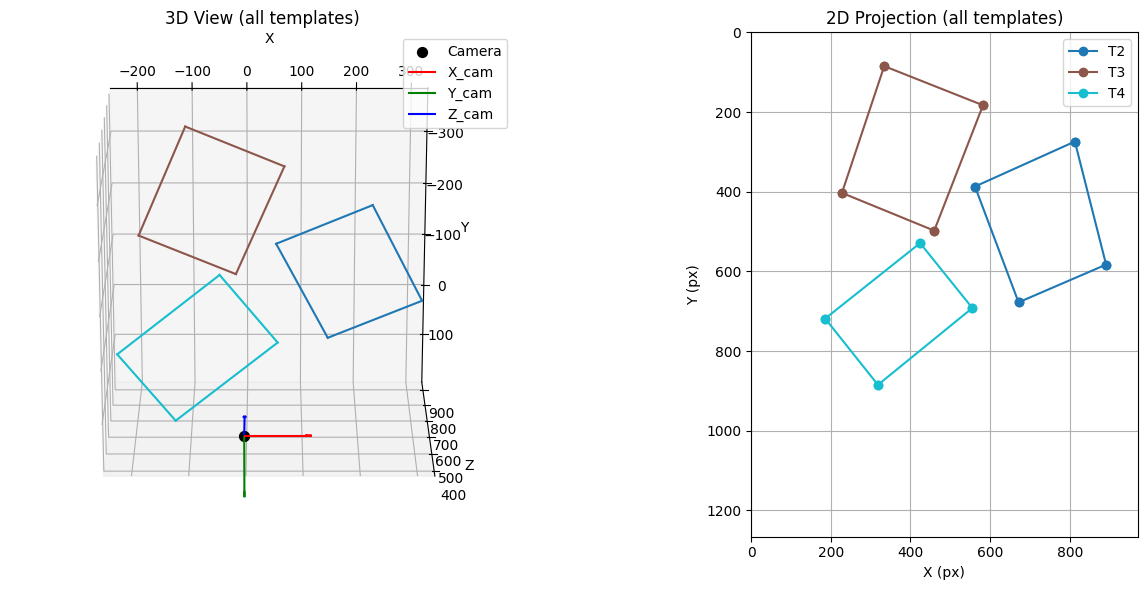

In [8]:
# Create the multi-template visualizer
visualizer = MultiTemplateVisualizer(
    metadata=metadata,
    results=results,
    K=K,
    fig_size=(14, 6),
    view_elev=-70,
    view_azim=-90,
)

# Plot the results
visualizer.plot()

In [9]:
# Extract chosen template
template_id = 'T2'
data = metadata[template_id]
data

Template(id='T2', label='PDJ Book', path='assets/templates/template_02.jpg', width=185.0, height=242.0)

In [10]:
# Decompose homography to recover camera pose
H = np.array(results[template_id]['homography'])
solutions = recover_all_poses_from_homography(H, K)

# Select the best solution based on expected constraints
R, t, n = select_best_solution(solutions, expected_z_positive=True)

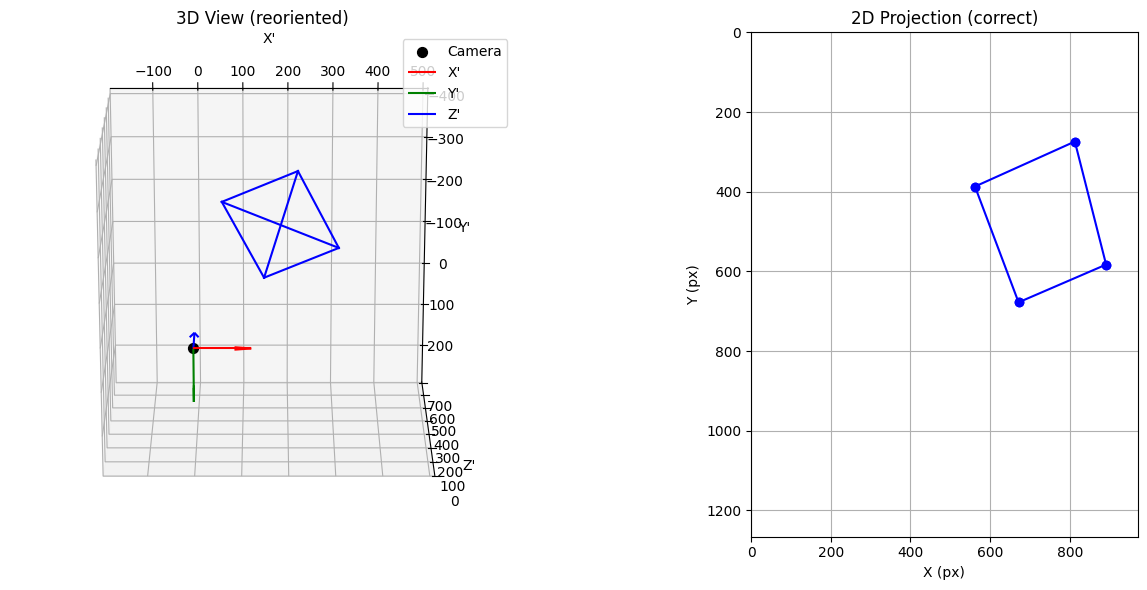

In [11]:
# Create the visualizer
visualizer = Plot3DVisualizerTest(
    template_size=np.array([data.width, data.height]),
    K=K,
    R=R,
    translation=t,
    view_elev=-70,
    view_azim=-90,
)

visualizer.plot()